# Speech Emotion Recognition With Convolutional Neural Network

# Content
1. [Including Libraries](#1)
2. [Including the Datasets](#2)
3. [Data Analyze](#3)
    * [Audio Augmentation](#7)
        * [Original Audio](#4)
        * [Noised Audio](#8)
        * [Streched Audio](#10)
        * [Shifted Audio](#11)
        * [Pitched Audio](#12)
    * [Feature Extraction](#13)
    * [Processing](#14)
4. [Including Analyzed Audio Features](#15)
5. [Processing Analyzed Data for Training](#16)
    * [Train, Test and Validation Spliting](#17)
    * [Tuning for Training](#18)
6. [Begin Training](#19)
7. [Drawing Charts](#20)
    * [Accuracy Charts](#21)
    * [Loss Charts](#22)
8. [Testing Model and Test Results](#24)
    * [Confusion Matrix](#25)

<a id="1"></a>
# Including Libraries

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import librosa
import librosa.display
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
import seaborn as sns
import IPython
import tensorflow.keras.layers as L
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder,StandardScaler
import re
import itertools
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


<a id="2"></a>
# Including the Datasets

In [2]:
Crema_Path='../input/speech-emotion-recognition-en/Crema/'
Ravdess_Path='../input/speech-emotion-recognition-en/Ravdess/audio_speech_actors_01-24'
Savee_Path='../input/speech-emotion-recognition-en/Savee/'
Tess_Path='../input/speech-emotion-recognition-en/Tess/'

<a id="3"></a>
# Data Analyze

In [3]:
crema=[]
for wav in os.listdir(Crema_Path):
    emotion=wav.partition(".wav")[0].split('_')
    if emotion[2]=='SAD':
        crema.append(('sad',Crema_Path+'/'+wav))
    elif emotion[2]=='ANG':
        crema.append(('angry',Crema_Path+'/'+wav))
    elif emotion[2]=='DIS':
        crema.append(('disgust',Crema_Path+'/'+wav))
    elif emotion[2]=='FEA':
        crema.append(('fear',Crema_Path+'/'+wav))
    elif emotion[2]=='HAP':
        crema.append(('happy',Crema_Path+'/'+wav))
    elif emotion[2]=='NEU':
        crema.append(('neutral',Crema_Path+'/'+wav))
    else:
        crema.append(('unknown',Crema_Path+'/'+wav))
Crema_df=pd.DataFrame.from_dict(crema)
Crema_df.rename(columns={0:'Emotion',1:'File_Path'},inplace=True)
Crema_df.head()

,Emotion,File_Path
0,disgust,../input/speech-emotion-recognition-en/Crema//...
1,happy,../input/speech-emotion-recognition-en/Crema//...
2,happy,../input/speech-emotion-recognition-en/Crema//...
3,disgust,../input/speech-emotion-recognition-en/Crema//...
4,disgust,../input/speech-emotion-recognition-en/Crema//...


In [4]:
Crema_df['Emotion'].unique()

array(['disgust', 'happy', 'sad', 'neutral', 'fear', 'angry'],
      dtype=object)

In [5]:
ravdess=[]
for directory in os.listdir(Ravdess_Path):
    actors=os.listdir(os.path.join(Ravdess_Path,directory))
    for wav in actors:
        emotion=wav.partition('.wav')[0].split('-')
        emotion_number=int(emotion[2])
        ravdess.append((emotion_number,os.path.join(Ravdess_Path,directory,wav)))
Ravdess_df=pd.DataFrame.from_dict(ravdess)
Ravdess_df.rename(columns={0:'Emotion',1:'File_Path'},inplace=True)
Ravdess_df['Emotion'].replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'},inplace=True)
Ravdess_df.head()

,Emotion,File_Path
0,surprise,../input/speech-emotion-recognition-en/Ravdess...
1,neutral,../input/speech-emotion-recognition-en/Ravdess...
2,disgust,../input/speech-emotion-recognition-en/Ravdess...
3,disgust,../input/speech-emotion-recognition-en/Ravdess...
4,neutral,../input/speech-emotion-recognition-en/Ravdess...


In [6]:
Ravdess_df['Emotion'].unique()

array(['surprise', 'neutral', 'disgust', 'fear', 'sad', 'happy', 'angry'],
      dtype=object)

In [7]:
savee=[]
for wav in os.listdir(Savee_Path):
    emo=wav.partition('.wav')[0].split('_')[1].replace(r'[0-9]','')
    emotion=re.split(r'[0-9]',emo)[0]
    if emotion=='a':
        savee.append(('angry',Savee_Path+'/'+wav))
    elif emotion=='d':
        savee.append(('disgust',Savee_Path+'/'+wav))
    elif emotion=='f':
        savee.append(('fear',Savee_Path+'/'+wav))
    elif emotion=='h':
        savee.append(('happy',Savee_Path+'/'+wav))
    elif emotion=='n':
        savee.append(('neutral',Savee_Path+'/'+wav))
    elif emotion=='sa':
        savee.append(('sad',Savee_Path+'/'+wav))
    elif emotion=='su':
        savee.append(('surprise',Savee_Path+'/'+wav))
Savee_df=pd.DataFrame.from_dict(savee)
Savee_df.rename(columns={0:'Emotion',1:'File_Path'},inplace=True)
Savee_df.head()

,Emotion,File_Path
0,happy,../input/speech-emotion-recognition-en/Savee//...
1,fear,../input/speech-emotion-recognition-en/Savee//...
2,happy,../input/speech-emotion-recognition-en/Savee//...
3,disgust,../input/speech-emotion-recognition-en/Savee//...
4,angry,../input/speech-emotion-recognition-en/Savee//...


In [8]:
Savee_df['Emotion'].unique()

array(['happy', 'fear', 'disgust', 'angry', 'surprise', 'neutral', 'sad'],
      dtype=object)

In [9]:
tess=[]
for directory in os.listdir(Tess_Path):
    for wav in os.listdir(os.path.join(Tess_Path,directory)):
        emotion=wav.partition('.wav')[0].split('_')
        if emotion[2]=='ps':
            tess.append(('surprise',os.path.join(Tess_Path,directory,wav)))
        else:
            tess.append((emotion[2],os.path.join(Tess_Path,directory,wav)))
Tess_df=pd.DataFrame.from_dict(tess)
Tess_df.rename(columns={0:'Emotion',1:'File_Path'},inplace=True)
Tess_df.head()

,Emotion,File_Path
0,fear,../input/speech-emotion-recognition-en/Tess/YA...
1,fear,../input/speech-emotion-recognition-en/Tess/YA...
2,fear,../input/speech-emotion-recognition-en/Tess/YA...
3,fear,../input/speech-emotion-recognition-en/Tess/YA...
4,fear,../input/speech-emotion-recognition-en/Tess/YA...


In [10]:
Tess_df['Emotion'].unique()

array(['fear', 'angry', 'disgust', 'neutral', 'sad', 'surprise', 'happy'],
      dtype=object)

In [11]:
main_df=pd.concat([Crema_df,Ravdess_df,Savee_df,Tess_df],axis=0)
main_df.shape

(12162, 2)

In [12]:
main_df.head(15)

,Emotion,File_Path
0,disgust,../input/speech-emotion-recognition-en/Crema//...
1,happy,../input/speech-emotion-recognition-en/Crema//...
2,happy,../input/speech-emotion-recognition-en/Crema//...
3,disgust,../input/speech-emotion-recognition-en/Crema//...
4,disgust,../input/speech-emotion-recognition-en/Crema//...
5,disgust,../input/speech-emotion-recognition-en/Crema//...
6,happy,../input/speech-emotion-recognition-en/Crema//...
7,sad,../input/speech-emotion-recognition-en/Crema//...
8,disgust,../input/speech-emotion-recognition-en/Crema//...
9,sad,../input/speech-emotion-recognition-en/Crema//...


In [13]:
main_df.tail(15)

,Emotion,File_Path
2785,surprise,../input/speech-emotion-recognition-en/Tess/YA...
2786,surprise,../input/speech-emotion-recognition-en/Tess/YA...
2787,surprise,../input/speech-emotion-recognition-en/Tess/YA...
2788,surprise,../input/speech-emotion-recognition-en/Tess/YA...
2789,surprise,../input/speech-emotion-recognition-en/Tess/YA...
2790,surprise,../input/speech-emotion-recognition-en/Tess/YA...
2791,surprise,../input/speech-emotion-recognition-en/Tess/YA...
2792,surprise,../input/speech-emotion-recognition-en/Tess/YA...
2793,surprise,../input/speech-emotion-recognition-en/Tess/YA...
2794,surprise,../input/speech-emotion-recognition-en/Tess/YA...


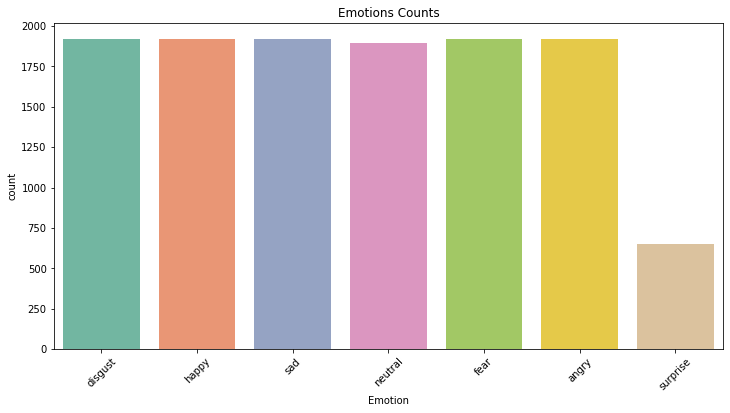

In [14]:
plt.figure(figsize=(12,6))
plt.title('Emotions Counts')
emotions=sns.countplot(x='Emotion',data=main_df,palette='Set2')
emotions.set_xticklabels(emotions.get_xticklabels(),rotation=45)
plt.show()

In [15]:
emotion_names=main_df['Emotion'].unique()

In [16]:
colors={'disgust':'#804E2D','happy':'#F19C0E','sad':'#478FB8','neutral':'#4CB847','fear':'#7D55AA','angry':'#C00808','surprise':'#EE00FF'}

In [17]:
def wave_plot(data,sr,emotion,color):
    plt.figure(figsize=(12,5))
    plt.title(f'{emotion} emotion for waveplot',size=17)
    librosa.display.waveshow(y=data,sr=sr,color=color)

In [18]:
def spectogram(data,sr,emotion):
    audio=librosa.stft(data)
    audio_db=librosa.amplitude_to_db(abs(audio))
    plt.figure(figsize=(12,5))
    plt.title(f'{emotion} emotion for spectogram',size=17)
    librosa.display.specshow(audio_db,sr=sr,x_axis='time',y_axis='hz')

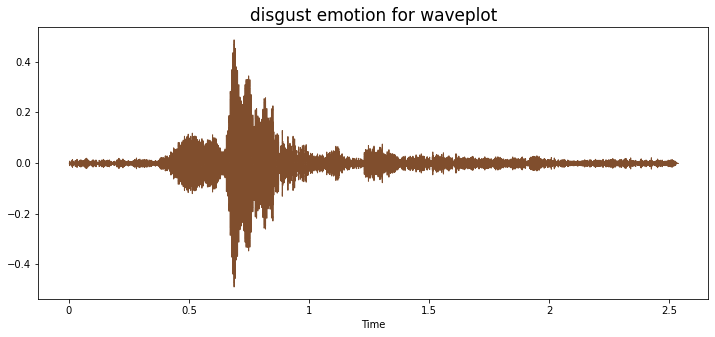

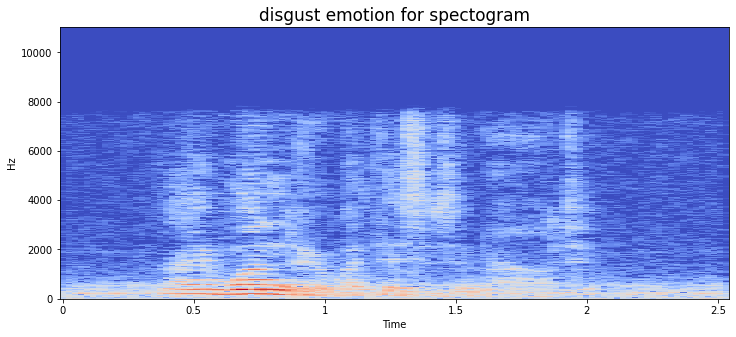

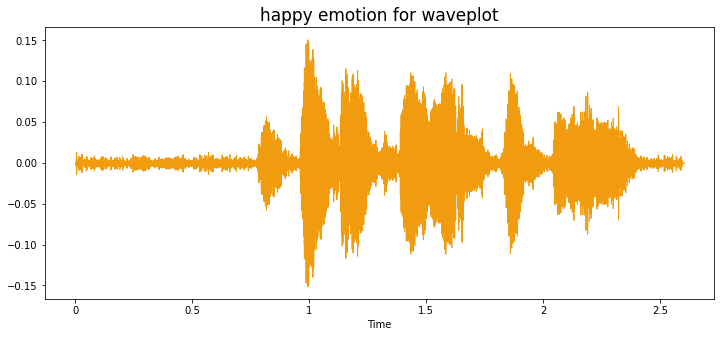

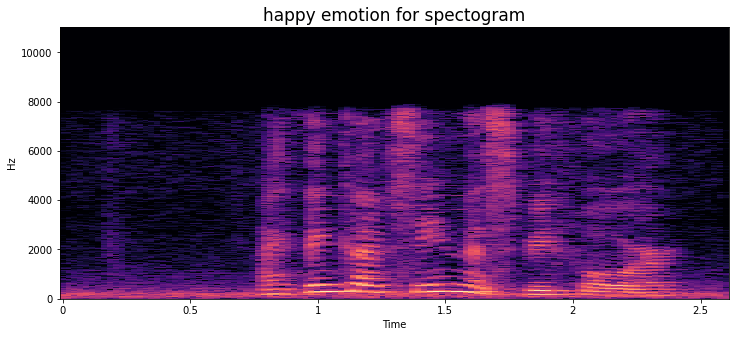

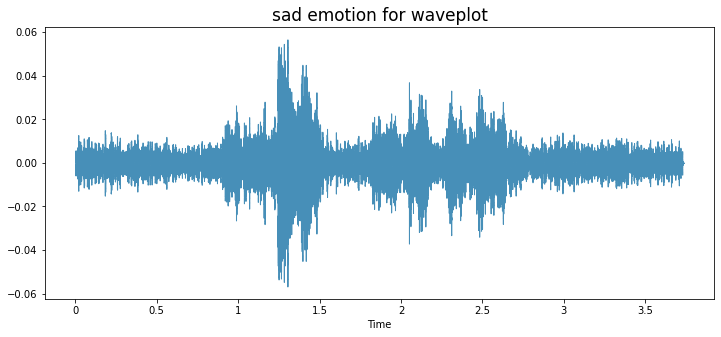

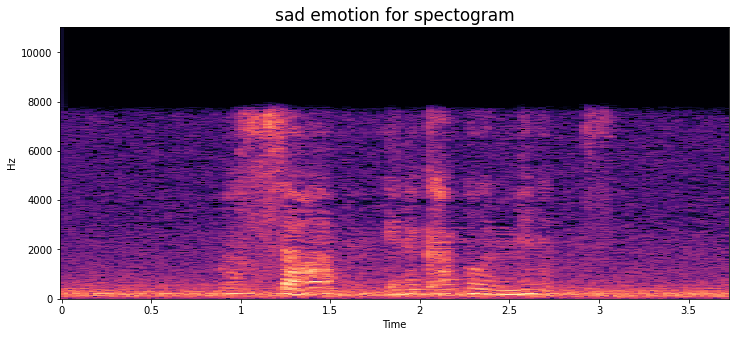

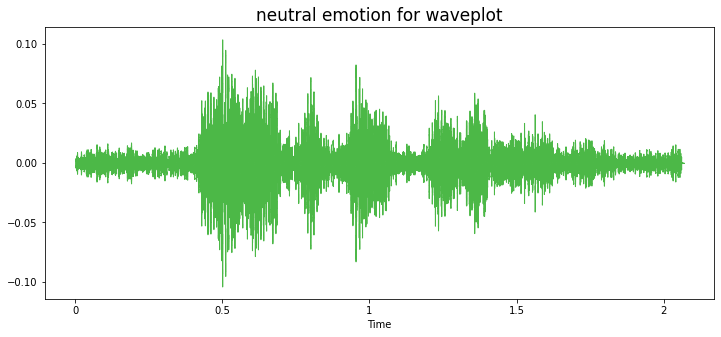

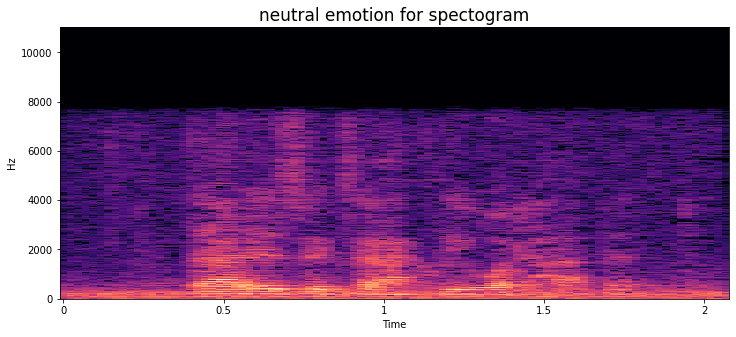

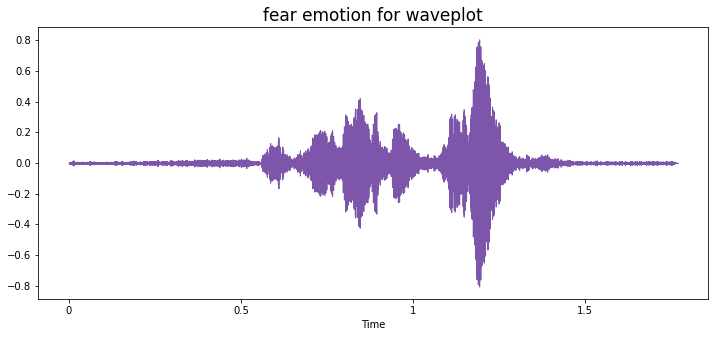

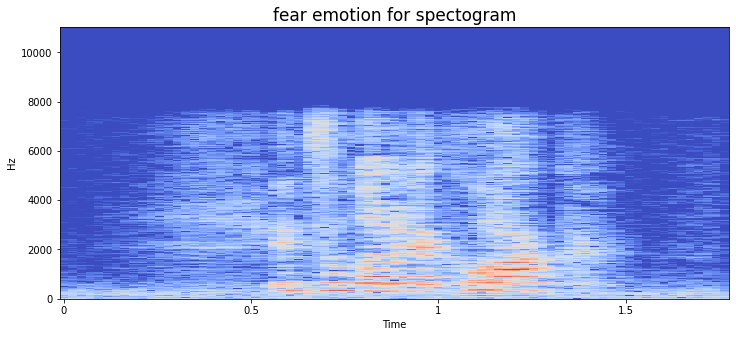

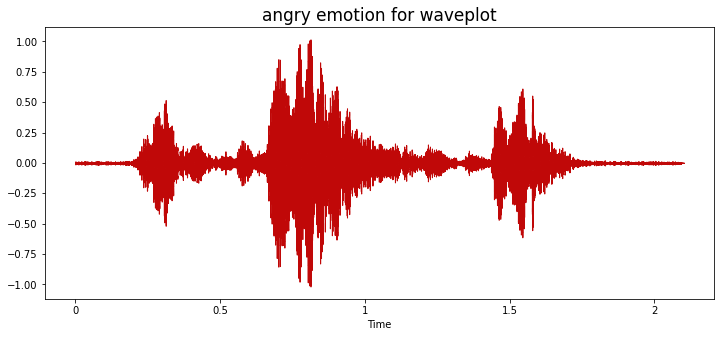

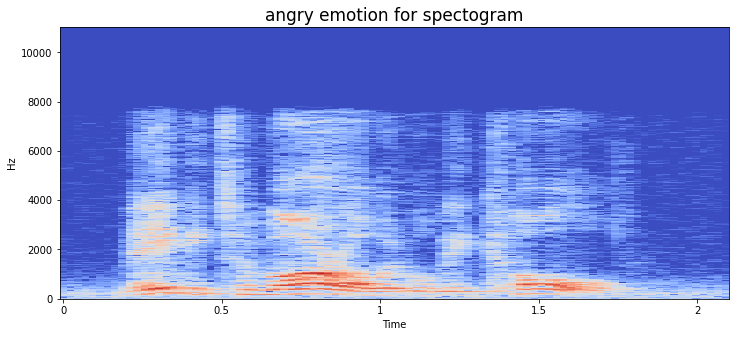

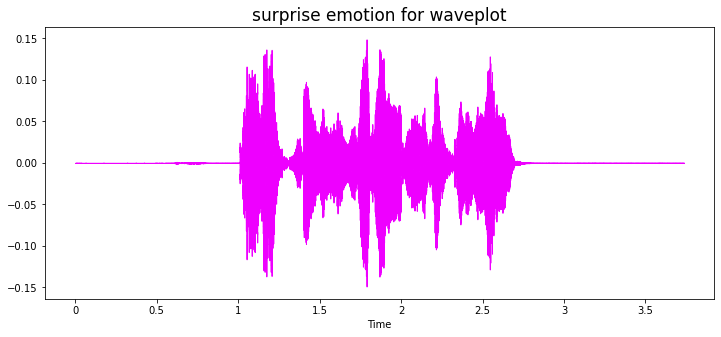

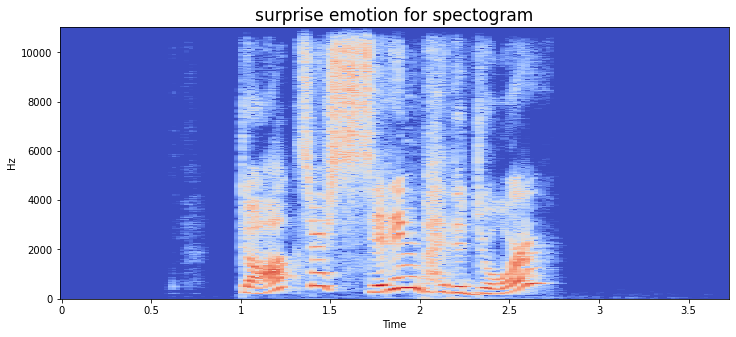

In [19]:
audio_path=[]
for emotion in emotion_names:
    path=np.array(main_df['File_Path'][main_df['Emotion']==emotion])[1]
    data,sr=librosa.load(path)
    wave_plot(data,sr,emotion,colors[emotion])
    spectogram(data,sr,emotion)
    audio_path.append(path)

In [20]:
print('Disgust Audio Sample\n')
IPython.display.Audio(audio_path[0])

Disgust Audio Sample



In [21]:
print('Happy Audio Sample\n')
IPython.display.Audio(audio_path[1])

Happy Audio Sample



In [22]:
print('Sad Audio Sample\n')
IPython.display.Audio(audio_path[2])

Sad Audio Sample



In [23]:
print('Neutral Audio Sample\n')
IPython.display.Audio(audio_path[3])

Neutral Audio Sample



In [24]:
print('Fear Audio Sample\n')
IPython.display.Audio(audio_path[4])

Fear Audio Sample



In [25]:
print('Angry Audio Sample\n')
IPython.display.Audio(audio_path[5])

Angry Audio Sample



In [26]:
print('Surprise Audio Sample\n')
IPython.display.Audio(audio_path[6])

Surprise Audio Sample



<a id="7"></a>
## Audio Augmentation

In [27]:
def add_noise(data,random=False,rate=0.035,threshold=0.075):
    if random:
        rate=np.random.random()*threshold
    noise=rate*np.random.uniform()*np.amax(data)
    augmented_data=data+noise*np.random.normal(size=data.shape[0])
    return augmented_data

def shifting(data,rate=1000):
    augmented_data=int(np.random.uniform(low=-5,high=5)*rate)
    augmented_data=np.roll(data,augmented_data)
    return augmented_data

def pitching(data,sr,pitch_factor=0.7,random=False):
    if random:
        pitch_factor=np.random.random() * pitch_factor
    return librosa.effects.pitch_shift(data,sr,pitch_factor)

def streching(data,rate=0.8):
    return librosa.effects.time_stretch(data,rate)
    

In [28]:
data,sr=librosa.load(audio_path[6])

<a id="4"></a>
### Orijinal Audio

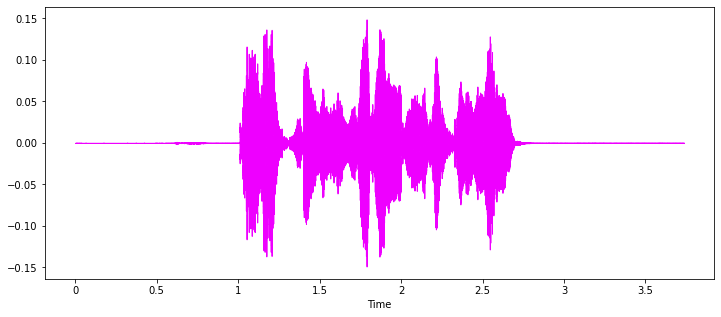

In [29]:
plt.figure(figsize=(12,5))
librosa.display.waveshow(data,sr,color='#EE00FF')
IPython.display.Audio(audio_path[6])

<a id="8"></a>
### Noised Audio

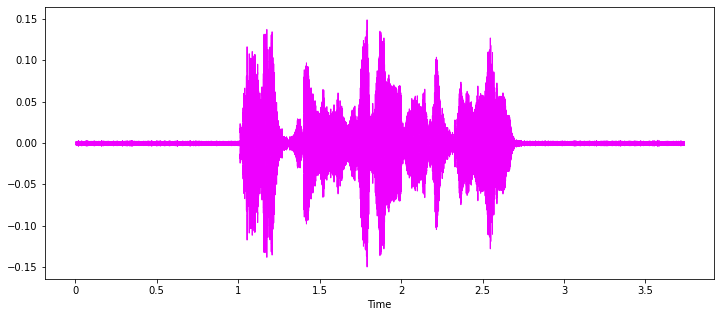

In [30]:
noised_audio=add_noise(data)
plt.figure(figsize=(12,5))
librosa.display.waveshow(noised_audio,sr,color='#EE00FF')
IPython.display.Audio(noised_audio,rate=sr)

<a id="10"></a>
### Streched Audio

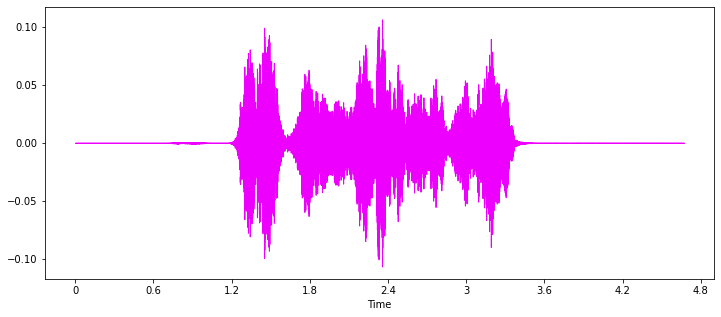

In [31]:
stretched_audio=streching(data)
plt.figure(figsize=(12,5))
librosa.display.waveshow(stretched_audio,sr,color='#EE00FF')
IPython.display.Audio(stretched_audio,rate=sr)

<a id="11"></a>
### Shifted Audio

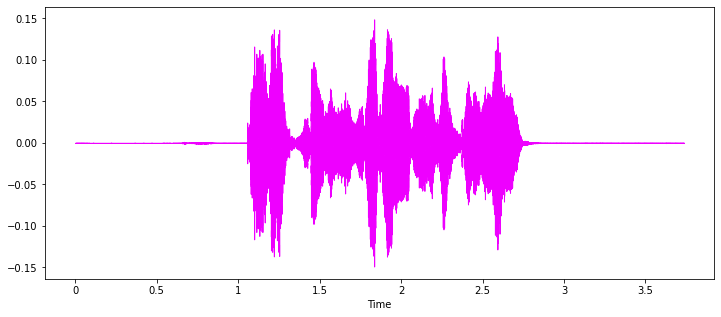

In [32]:
shifted_audio=shifting(data)
plt.figure(figsize=(12,5))
librosa.display.waveshow(shifted_audio,sr,color='#EE00FF')
IPython.display.Audio(shifted_audio,rate=sr)

<a id="12"></a>
### Pitched Audio

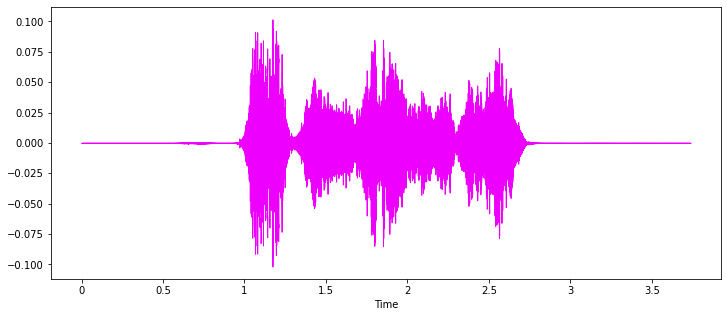

In [33]:
pitched_audio=pitching(data,sr)
plt.figure(figsize=(12,5))
librosa.display.waveshow(pitched_audio,sr,color='#EE00FF')
IPython.display.Audio(pitched_audio,rate=sr)

<a id="13"></a>
## Feature Extraction

In [34]:
def zcr(data,frame_length,hop_length):
    zcr=librosa.feature.zero_crossing_rate(data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(zcr)
def rmse(data,frame_length=2048,hop_length=512):
    rmse=librosa.feature.rms(data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(rmse)
def mfcc(data,sr,frame_length=2048,hop_length=512,flatten:bool=True):
    mfcc=librosa.feature.mfcc(data,sr=sr)
    return np.squeeze(mfcc.T)if not flatten else np.ravel(mfcc.T)

def extract_features(data,sr,frame_length=2048,hop_length=512):
    result=np.array([])
    
    result=np.hstack((result,
                      zcr(data,frame_length,hop_length),
                      rmse(data,frame_length,hop_length),
                      mfcc(data,sr,frame_length,hop_length)
                     ))
    return result

def get_features(path,duration=2.5, offset=0.6):
    data,sr=librosa.load(path,duration=duration,offset=offset)
    aud=extract_features(data,sr)
    audio=np.array(aud)
    
    noised_audio=add_noise(data,random=True)
    aud2=extract_features(noised_audio,sr)
    audio=np.vstack((audio,aud2))
    
    pitched_audio=pitching(data,sr,random=True)
    aud3=extract_features(pitched_audio,sr)
    audio=np.vstack((audio,aud3))
    
    pitched_audio1=pitching(data,sr,random=True)
    pitched_noised_audio=add_noise(pitched_audio1,random=True)
    aud4=extract_features(pitched_noised_audio,sr)
    audio=np.vstack((audio,aud4))
    
    return audio

<a id="14"></a>
## Processing

In [35]:
X,Y=[],[]
for path,emotion,index in zip(main_df.File_Path,main_df.Emotion,range(main_df.File_Path.shape[0])):
    features=get_features(path)
    if index%500==0:
        print(f'{index} audio has been processed')
    for i in features:
        X.append(i)
        Y.append(emotion)
print('Done')

0 audio has been processed
500 audio has been processed
1000 audio has been processed
1500 audio has been processed
2000 audio has been processed
2500 audio has been processed
3000 audio has been processed
3500 audio has been processed
4000 audio has been processed
4500 audio has been processed
5000 audio has been processed
5500 audio has been processed
6000 audio has been processed
6500 audio has been processed
7000 audio has been processed
7500 audio has been processed
8000 audio has been processed
8500 audio has been processed
9000 audio has been processed
9500 audio has been processed
10000 audio has been processed
10500 audio has been processed
11000 audio has been processed
11500 audio has been processed
12000 audio has been processed
Done


In [36]:
processed_data_path='./processed_data.csv'

In [37]:
extract=pd.DataFrame(X)
extract['Emotion']=Y
extract.to_csv(processed_data_path,index=False)
extract.head(10)

,0,1,2,3,4,5,6,7,8,9,...,2367,2368,2369,2370,2371,2372,2373,2374,2375,Emotion
0,0.121094,0.187012,0.234863,0.244629,0.244629,0.239746,0.231445,0.178711,0.123535,0.073730,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,disgust
1,0.121094,0.188965,0.238770,0.249512,0.254395,0.251465,0.246094,0.195312,0.137207,0.083496,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,disgust
2,0.124512,0.173828,0.222656,0.236816,0.246094,0.251465,0.229980,0.169434,0.107422,0.063965,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,disgust
3,0.125488,0.176270,0.230469,0.250977,0.260254,0.280273,0.257812,0.195801,0.136230,0.078613,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,disgust
4,0.016113,0.021484,0.029297,0.030762,0.033691,0.036133,0.038574,0.046875,0.054688,0.062500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,happy
5,0.020996,0.030273,0.043945,0.057617,0.069824,0.084961,0.094238,0.098633,0.099121,0.095703,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,happy
6,0.017578,0.024902,0.034180,0.036621,0.040527,0.039062,0.042480,0.046875,0.053711,0.061523,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,happy
7,0.017090,0.023438,0.033203,0.035645,0.038574,0.041016,0.041504,0.047852,0.054688,0.059570,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,happy
8,0.013184,0.020020,0.026855,0.028809,0.026855,0.031250,0.036133,0.040527,0.050293,0.054199,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,happy
9,0.198242,0.298828,0.390625,0.380859,0.388672,0.393066,0.386230,0.328613,0.268066,0.193359,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,happy


<a id="15"></a>
# Including Analyzed Audio Features

In [38]:
df=pd.read_csv(processed_data_path)
df.shape

(48648, 2377)

In [39]:
df=df.fillna(0)
print(df.isna().any())
df.shape

0          False
1          False
2          False
3          False
4          False
           ...  
2372       False
2373       False
2374       False
2375       False
Emotion    False
Length: 2377, dtype: bool


(48648, 2377)

In [40]:
df.head(10)

,0,1,2,3,4,5,6,7,8,9,...,2367,2368,2369,2370,2371,2372,2373,2374,2375,Emotion
0,0.121094,0.187012,0.234863,0.244629,0.244629,0.239746,0.231445,0.178711,0.123535,0.073730,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,disgust
1,0.121094,0.188965,0.238770,0.249512,0.254395,0.251465,0.246094,0.195312,0.137207,0.083496,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,disgust
2,0.124512,0.173828,0.222656,0.236816,0.246094,0.251465,0.229980,0.169434,0.107422,0.063965,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,disgust
3,0.125488,0.176270,0.230469,0.250977,0.260254,0.280273,0.257812,0.195801,0.136230,0.078613,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,disgust
4,0.016113,0.021484,0.029297,0.030762,0.033691,0.036133,0.038574,0.046875,0.054688,0.062500,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,happy
5,0.020996,0.030273,0.043945,0.057617,0.069824,0.084961,0.094238,0.098633,0.099121,0.095703,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,happy
6,0.017578,0.024902,0.034180,0.036621,0.040527,0.039062,0.042480,0.046875,0.053711,0.061523,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,happy
7,0.017090,0.023438,0.033203,0.035645,0.038574,0.041016,0.041504,0.047852,0.054688,0.059570,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,happy
8,0.013184,0.020020,0.026855,0.028809,0.026855,0.031250,0.036133,0.040527,0.050293,0.054199,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,happy
9,0.198242,0.298828,0.390625,0.380859,0.388672,0.393066,0.386230,0.328613,0.268066,0.193359,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,happy


<a id="16"></a>
# Processing Analyzed Data for Training

In [41]:
X=df.drop(labels='Emotion',axis=1)
Y=df['Emotion']

In [42]:
lb=LabelEncoder()
Y=np_utils.to_categorical(lb.fit_transform(Y))
print(lb.classes_)
Y

['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']


array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

<a id="17"></a>
## Train, Test and Validation Spliting

In [43]:
X_train,X_test,y_train,y_test=train_test_split(X,Y,random_state=42,test_size=0.2,shuffle=True)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((38918, 2376), (9730, 2376), (38918, 7), (9730, 7))

In [44]:
X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,random_state=42,test_size=0.1,shuffle=True)
X_train.shape, X_test.shape, X_val.shape, y_train.shape,y_test.shape,y_val.shape

((35026, 2376), (9730, 2376), (3892, 2376), (35026, 7), (9730, 7), (3892, 7))

In [45]:
scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)
X_val=scaler.transform(X_val)
X_train.shape,X_test.shape,X_val.shape,y_train.shape,y_test.shape,y_val.shape

((35026, 2376), (9730, 2376), (3892, 2376), (35026, 7), (9730, 7), (3892, 7))

In [46]:
X_train=np.expand_dims(X_train,axis=2)
X_val=np.expand_dims(X_val,axis=2)
X_test=np.expand_dims(X_test,axis=2)
X_train.shape, X_test.shape, X_val.shape

((35026, 2376, 1), (9730, 2376, 1), (3892, 2376, 1))

<a id="18"></a>
## Tuning for Training

In [47]:
early_stop=EarlyStopping(monitor='val_acc',mode='auto',patience=5,restore_best_weights=True)
lr_reduction=ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.5,min_lr=0.00001)

In [48]:
EPOCH=50
BATCH_SIZE=64

<a id="19"></a>
# Begin Training

In [49]:
model=tf.keras.Sequential([
    L.Conv1D(512,kernel_size=5, strides=1,padding='same', activation='relu',input_shape=(X_train.shape[1],1)),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    L.Conv1D(512,kernel_size=5,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    L.Conv1D(256,kernel_size=5,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    L.Conv1D(256,kernel_size=3,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    L.Conv1D(128,kernel_size=3,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=3,strides=2,padding='same'),
    L.Flatten(),
    L.Dense(512,activation='relu'),
    L.BatchNormalization(),
    L.Dense(7,activation='softmax')
])
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics='accuracy')
model.summary()

2022-07-01 14:36:56.182241: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-01 14:36:56.187134: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-01 14:36:56.187865: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-01 14:36:56.190483: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 2376, 512)         3072      
_________________________________________________________________
batch_normalization (BatchNo (None, 2376, 512)         2048      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1188, 512)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1188, 512)         1311232   
_________________________________________________________________
batch_normalization_1 (Batch (None, 1188, 512)         2048      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 594, 512)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 594, 256)          6

In [50]:
history=model.fit(X_train, y_train, epochs=EPOCH, validation_data=(X_val,y_val), batch_size=BATCH_SIZE,callbacks=[early_stop,lr_reduction])

2022-07-01 14:36:59.499328: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 332887104 exceeds 10% of free system memory.
2022-07-01 14:36:59.892120: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 332887104 exceeds 10% of free system memory.
2022-07-01 14:37:00.167745: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-07-01 14:37:02.868869: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


548/548 [==============================] - ETA: 0s - loss: 1.3738 - accuracy: 0.4806

2022-07-01 14:38:37.762305: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 36989568 exceeds 10% of free system memory.
2022-07-01 14:38:37.796587: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 36989568 exceeds 10% of free system memory.


548/548 [==============================] - 100s 167ms/step - loss: 1.3738 - accuracy: 0.4806 - val_loss: 1.3485 - val_accuracy: 0.4815
Epoch 2/50
548/548 [==============================] - 91s 166ms/step - loss: 1.0777 - accuracy: 0.5862 - val_loss: 1.0651 - val_accuracy: 0.5964
Epoch 3/50
548/548 [==============================] - 91s 166ms/step - loss: 0.9473 - accuracy: 0.6360 - val_loss: 1.3258 - val_accuracy: 0.5092
Epoch 4/50
548/548 [==============================] - 91s 166ms/step - loss: 0.8250 - accuracy: 0.6861 - val_loss: 0.9226 - val_accuracy: 0.6506
Epoch 5/50
548/548 [==============================] - 91s 166ms/step - loss: 0.7015 - accuracy: 0.7383 - val_loss: 0.7838 - val_accuracy: 0.7097
Epoch 6/50
548/548 [==============================] - 91s 166ms/step - loss: 0.5311 - accuracy: 0.8072 - val_loss: 0.7225 - val_accuracy: 0.7325
Epoch 7/50
548/548 [==============================] - 91s 166ms/step - loss: 0.3939 - accuracy: 0.8595 - val_loss: 0.6583 - val_accuracy: 0.

<a id="20"></a>
# Drawing Charts

<a id="21"></a>
## Accuracy Charts

In [51]:
fig=px.line(history.history,y=['accuracy','val_accuracy'],
           labels={'index':'epoch','value':'accuracy'},
           title=f'According to the epoch accuracy and validation accuracy chart for the model')
fig.show()

<a id="22"></a>
## Loss Charts

In [52]:
fig=px.line(history.history,y=['loss','val_loss'],
           labels={'index':'epoch','value':'loss'},
           title=f'According to the epoch loss and validation loss chart for the model')
fig.show()

<a id="24"></a>
# Testing Model and Test Results

In [53]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_pred

2022-07-01 15:53:31.286309: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 92473920 exceeds 10% of free system memory.


array([3, 3, 0, ..., 4, 4, 3])

In [54]:
y_check=np.argmax(y_test,axis=1)
y_check

array([3, 3, 0, ..., 4, 4, 3])

In [55]:
loss,accuracy=model.evaluate(X_test,y_test,verbose=0)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

Test Loss: 0.3653544485569
Test Accuracy: 0.922404944896698


<a id="25"></a>
## Confusion Matrix

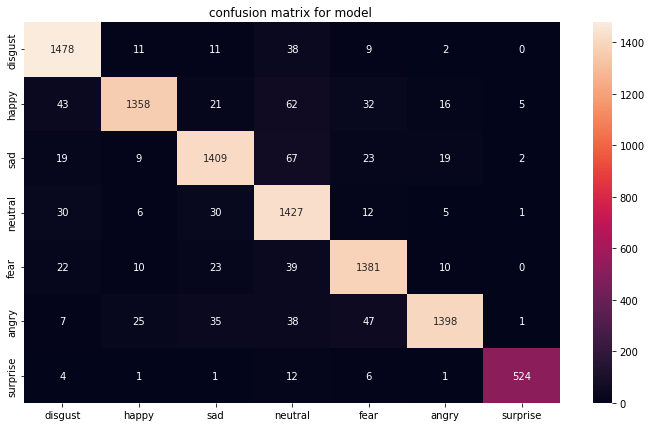

In [56]:
conf=confusion_matrix(y_check,y_pred)
cm=pd.DataFrame(
    conf,index=[i for i in emotion_names],
    columns=[i for i in emotion_names]
)
plt.figure(figsize=(12,7))
ax=sns.heatmap(cm,annot=True,fmt='d')
ax.set_title(f'confusion matrix for model ')
plt.show()

In [57]:
print(f'Model Confusion Matrix\n',classification_report(y_check,y_pred,target_names=emotion_names))

Model Confusion Matrix
               precision    recall  f1-score   support

     disgust       0.92      0.95      0.94      1549
       happy       0.96      0.88      0.92      1537
         sad       0.92      0.91      0.92      1548
     neutral       0.85      0.94      0.89      1511
        fear       0.91      0.93      0.92      1485
       angry       0.96      0.90      0.93      1551
    surprise       0.98      0.95      0.97       549

    accuracy                           0.92      9730
   macro avg       0.93      0.93      0.93      9730
weighted avg       0.92      0.92      0.92      9730



In [58]:
model_path = "./res_model.h5"

model.save(model_path)